# Image processing with Python
[Original course is here](https://datacarpentry.org/image-processing/09-contours/). Review the original course if you want to know more. This is my replica of it.

[GitHub source code](https://github.com/datacarpentry/image-processing/tree/gh-pages/code) of the original course.

[Get your monitor DPI here](https://www.infobyip.com/detectmonitordpi.php)

## Make preparations

In [16]:
!pip3 install numpy
!pip3 install scipy
!pip3 install scikit-image
!pip3 install matplotlib
!pip3 install opencv-contrib-python

Download images for further processing them with Python.

In [20]:
import os
imgs = os.path.join("..", "data")  # directory with images
temp = os.path.join("..", "temp")  # directory with temporary images
img1 = os.path.join(imgs, "2019.11.14_contours_junk.jpg")
img2 = os.path.join(imgs, "2019.11.14_contours_dice.jpg")
img3 = os.path.join(imgs, "2019.11.15_contours_dice.jpg")
img4 = os.path.join(imgs, "2019.11.15_contours_dots.jpg")
img5 = os.path.join(imgs, "2019.11.15_contours_leaf.jpg")
img6 = os.path.join(imgs, "2019.12.02_chair.jpg")

my_dpi = 96  # dots per inch

Small bash script to download and rename necessary images into "data" directory.

In [21]:
%%bash -s "$imgs" "temp" "$img1" "$img2" "$img3" "$img4" "$img5" "$img6"

# Create directories if they do not exist
if [ ! -d $1 ]
then
    mkdir $1
fi

if [ ! -d $2 ]
then
    mkdir $2
fi

# Get necessary images
if [ ! -f $3 ]
then
    wget https://datacarpentry.org/image-processing/fig/06-junk-before.jpg -O $3
fi

if [ ! -f $4 ]
then
    wget https://datacarpentry.org/image-processing/fig/08-dice.jpg -O $4
fi

if [ ! -f $5 ]
then
    wget https://datacarpentry.org/image-processing/fig/08-dice-grid.jpg -O $5
fi

if [ ! -f $6 ]
then
    wget https://datacarpentry.org/image-processing/fig/08-dots.jpg -O $6
fi

if [ ! -f $7 ]
then
    wget https://datacarpentry.org/image-processing/fig/08-leaf.jpg -O $7
fi

if [ ! -f $8 ]
then
    wget https://raw.githubusercontent.com/datacarpentry/image-processing/gh-pages/code/03-skimage-images/chair.jpg -O $8
fi


## Read, display, and save image

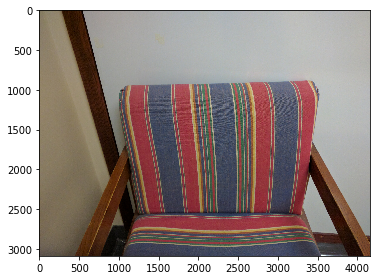

Image has shape: (3088, 4160, 3)
Small image has shape: (1544, 2080, 3)


In [81]:
import os
import warnings
import numpy as np

from skimage import io, transform, img_as_ubyte
from matplotlib import pyplot as plt

# Read image
image = io.imread(fname=img6)

# Display image
io.imshow(image)
plt.show()

# Resize the image
print("Image has shape:", image.shape)
new_shape = (image.shape[0] >> 1, image.shape[1] >> 1, image.shape[2])
small = transform.resize(image=image, output_shape=new_shape)
print("Small image has shape:", small.shape)

# UserWarning: Possible precision loss when converting from float64 to uint8
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Save a new version in .tif format
    io.imsave(fname=os.path.join(temp, "chair2.tif"), arr=img_as_ubyte(small))

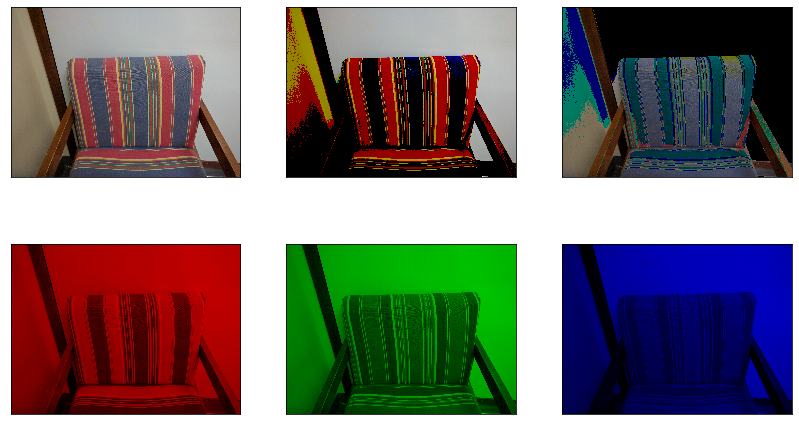

In [139]:
i = image.copy()
j = image.copy()
r = image.copy()
g = image.copy()
b = image.copy()
i[i < 128] = 0  # keep only high-intensity pixels
j[j > 128] = 0  # keep only low-intensity pixels
r[:,:,1] = 0
r[:,:,2] = 0
g[:,:,0] = 0
g[:,:,2] = 0
b[:,:,0] = 0
b[:,:,1] = 0

plt.figure(figsize=(14, 8))

ax = plt.subplot(231)
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.NullLocator())
plt.imshow(image)

ax = plt.subplot(232)
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.NullLocator())
plt.imshow(i)

ax = plt.subplot(233)
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.NullLocator())
plt.imshow(j)

ax = plt.subplot(234)
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.NullLocator())
plt.imshow(r)

ax = plt.subplot(235)
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.NullLocator())
plt.imshow(g)

ax = plt.subplot(236)
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.NullLocator())
plt.imshow(b)

plt.show()

## Contours
The difference between **edges** and **contours** is significant. When we perform edge detection, we find the points where the intensity of colors changes significantly, and turn those pixels on, while turning the rest of the pixels off. The edge pixels are in an image, and there is no particular requirement that the pixels representing an edge are all contiguous.

**Contours are not necessarily part of an image**, unless we choose to draw them. Rather, contours are abstract collections of points and / or line segments corresponding to the shapes of the objects in the image. Thus, they can be manipulated by our programs; we can count the number of contours, use them to categorize the shapes in the object, use them to crop objects from an image, and more. So, let us see how to find contours in an image, and use the contours to determine the number of objects in the image.

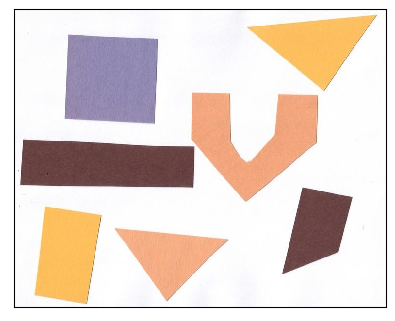

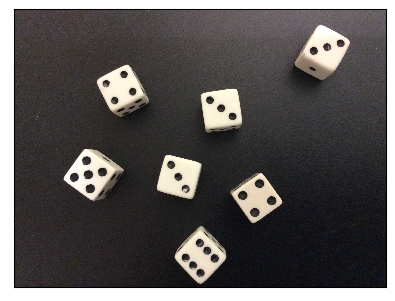

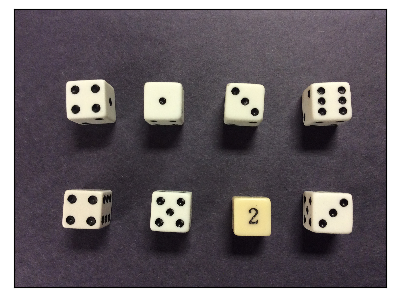

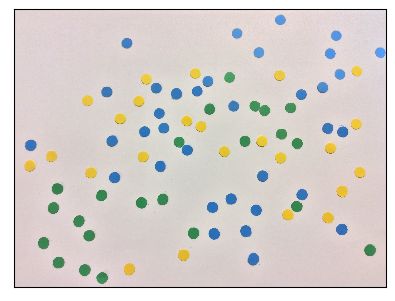

In [16]:
import cv2
import math
import numpy as np

from matplotlib import pyplot as plt


def get_contours(image,
                 mode=cv2.RETR_EXTERNAL,  # find outermost contours by default
                 method=cv2.CHAIN_APPROX_SIMPLE):
    """ Find contours both for OpenCV v3.x and v4.x """
    # Find the outermost contours, based on the binary dice image
    output = cv2.findContours(image=image, mode=mode, method=method)
    if len(output) == 3:  # (_, contours, hierarchy)
        return (output[1], output[2])
    elif len(output) == 2:  # (contours, hierarchy)
        return output


def get_size(image):
    """ Return image size in inches """
    size = image.shape[1::-1]  # image size in pixels
    return tuple(map(lambda x: int(x / my_dpi), size))


def get_image(name):
    """ Get image from path """
    image = cv2.imread(name)  # read image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert BGR to RGB
    return image


def get_gray(name):
    """ Get gray image from path """
    image = cv2.imread(name)  # read image
    # Convert BGR to gray
    image = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2GRAY)
    return image


def show_image(image, size=(10, 10)):
    """ Show image in Jupyter Notebook """
    plt.rcParams['figure.dpi'] = my_dpi  # set DPI
    plt.figure(figsize=size)  # set image size in inches
    plt.xticks([])  # hide x axis values
    plt.yticks([])  # hide y axis values
    plt.imshow(image)
    plt.show

    
def show_hist(name):
    """ Show histogram from image path """
    image = get_gray(name)
    plt.rcParams['figure.dpi'] = my_dpi  # set DPI
    plt.figure(figsize=(10, 10))  # set size in inches
    plt.hist(image.ravel(), bins=range(256))
    plt.show


def show_contours(name, thresh):
    """ Draw contours on the image and show it """
    # Create binary image
    threshold = thresh
    gray = get_gray(name)
    blur = cv2.GaussianBlur(src=gray, ksize=(5, 5), sigmaX=0)
    t, binary = cv2.threshold(src=blur, thresh=threshold,
                              maxval=255, type=cv2.THRESH_BINARY)

    # Find outermost contours
    contours, _ = get_contours(
        image=binary, 
        mode=cv2.RETR_EXTERNAL,  # find outermost contours
        method=cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the image
    image = get_image(name)
    cv2.drawContours(
        image=image, contours=contours, contourIdx=-1,
        color=(255, 0, 0), thickness=5)
    show_image(image)


# Run it twice if images are not appear
size = (5, 5)
show_image(get_image(img1), size)
show_image(get_image(img2), size)
show_image(get_image(img3), size)
show_image(get_image(img4), size)

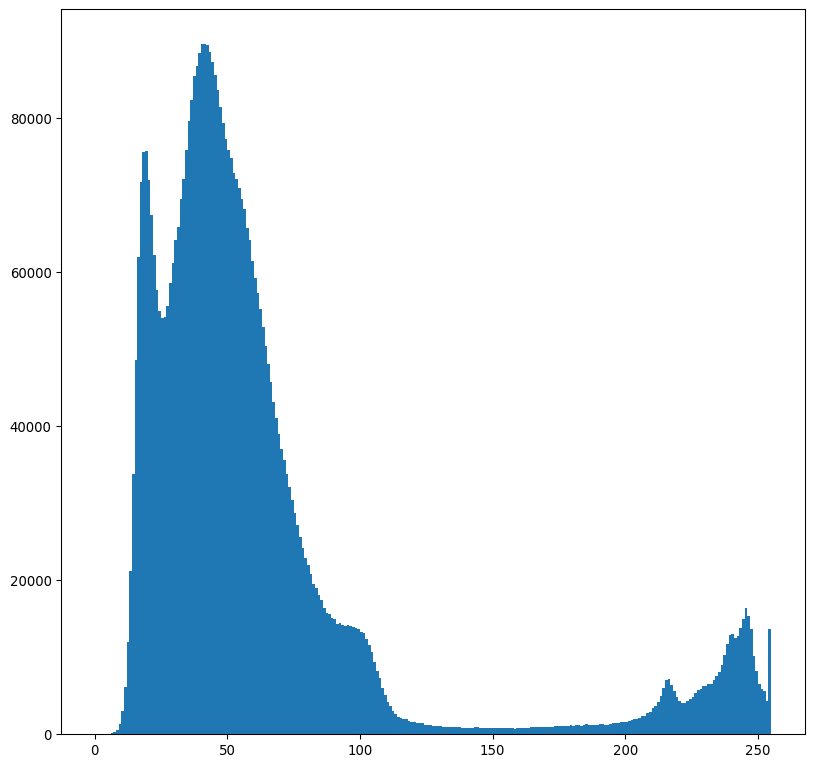

In [4]:
# Show histogram for dice image
show_hist(img2)

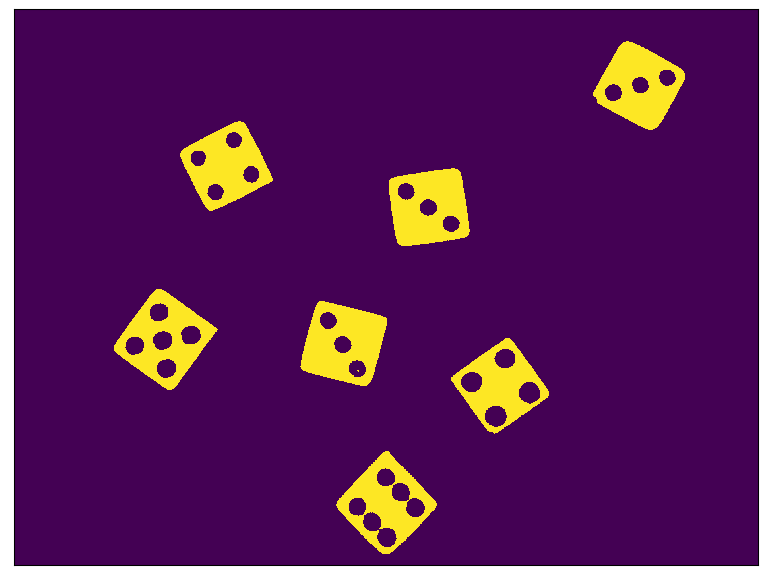

In [5]:
# Create and show binary image
threshold = 200  # choose threshold from histogram above
gray = get_gray(img2)
blur = cv2.GaussianBlur(src=gray, ksize=(5, 5), sigmaX=0)
t, binary = cv2.threshold(src=blur, thresh=threshold,
                            maxval=255, type=cv2.THRESH_BINARY)
show_image(binary)

### Using contours to count objects
The first parameter to the `cv2.findContours` function is the image to find contours in. Remember, this image should be binary, with the objects you wish to find contours for in white, against a black background. Second, we pass in a constant indicating what kind of contours we are interested in. Since we are interested in counting the objects in this image, we only care about the contours around the outermost edges of the objects, and so we pass in the `cv2.RETR_EXTERNAL` parameter. If we wished to have more information – say, contours associated with the pips on the faces of the dice – then we could use another parameter, such as `cv2.RETR_TREE` or `cv2.RETR_CCOMP`. See the OpenCV documentation [here](https://docs.opencv.org/trunk/d3/dc0/group__imgproc__shape.html#ga819779b9857cc2f8601e6526a3a5bc71) for more information. The last parameter tells the function if it should simplify the contours or not. We pass in `cv2.CHAIN_APPROX_SIMPLE`, which tells the function to simplify by using line segments when it can, rather that including all the points on what would be a straight edge. Using this parameter saves memory and computation time in our program.

Found 7 objects.
	Size of contour 1: 423
	Size of contour 2: 476
	Size of contour 3: 497
	Size of contour 4: 456
	Size of contour 5: 327
	Size of contour 6: 620
	Size of contour 7: 570


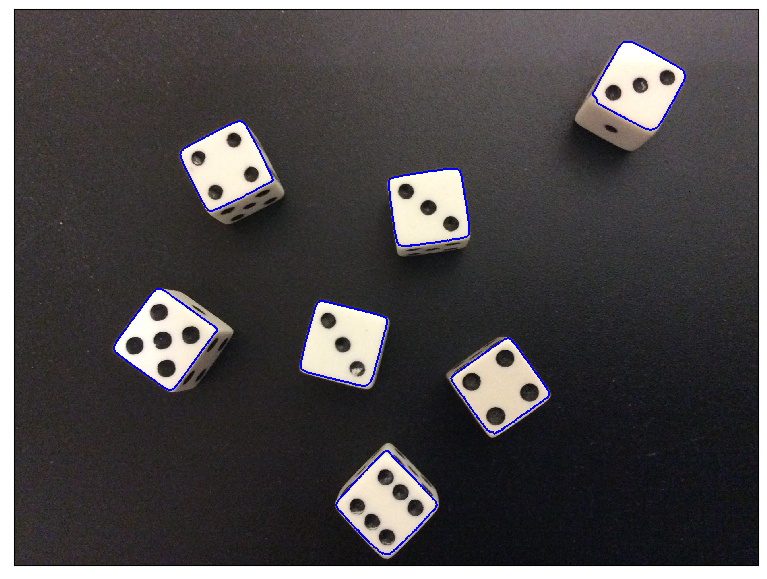

In [6]:
# Find the outermost contours, based on the binary dice image
contours, hierarchy = get_contours(binary)

# Print information about found contours
print(f"Found {len(contours)} objects.")
for i, c in enumerate(contours, 1):
    print(f"\tSize of contour {i}: {len(c)}")

# Draw the contour points on the original image
image = get_image(img2)
cv2.drawContours(
    image=image, contours=contours,
    contourIdx=-1, color=(0, 0, 255), thickness=5)
show_image(image)

### Understanding contour hierarchies

In [7]:
# Find all contours hierarchy
contours, hierarchy = get_contours(
    image=binary, 
    mode=cv2.RETR_TREE,  # find all contours hierarchy
    method=cv2.CHAIN_APPROX_SIMPLE)

# Print information about found contours
print(f"Found {len(contours)} objects.")
for i, c in enumerate(contours, 1):
    print(f"\tSize of contour {i}: {len(c)}")

# Print information about contours hierarchy
# [next, previous, first child, parent]
print(f"Contours hierarchy\n[next, previous, first child, parent]:")
for i, h in enumerate(hierarchy[0]):
    print(f"\t{i}: {h}")

dice = []  # list of dice contours
pips = []  # list of pip contours

# Find dice contours
for i, c in enumerate(hierarchy[0]):
    if c[3] == -1:
        dice.append(i)

# Find pip contours
for i, c in enumerate(hierarchy[0]):
    if c[3] in dice:
        pips.append(i)

print("Total dice rolls:", len(pips))

Found 36 objects.
	Size of contour 1: 423
	Size of contour 2: 184
	Size of contour 3: 105
	Size of contour 4: 98
	Size of contour 5: 92
	Size of contour 6: 103
	Size of contour 7: 476
	Size of contour 8: 106
	Size of contour 9: 116
	Size of contour 10: 106
	Size of contour 11: 101
	Size of contour 12: 497
	Size of contour 13: 86
	Size of contour 14: 6
	Size of contour 15: 11
	Size of contour 16: 78
	Size of contour 17: 84
	Size of contour 18: 456
	Size of contour 19: 90
	Size of contour 20: 97
	Size of contour 21: 98
	Size of contour 22: 95
	Size of contour 23: 77
	Size of contour 24: 327
	Size of contour 25: 90
	Size of contour 26: 81
	Size of contour 27: 80
	Size of contour 28: 620
	Size of contour 29: 83
	Size of contour 30: 87
	Size of contour 31: 76
	Size of contour 32: 80
	Size of contour 33: 570
	Size of contour 34: 90
	Size of contour 35: 90
	Size of contour 36: 69
Contours hierarchy
[next, previous, first child, parent]:
	0: [ 6 -1  1 -1]
	1: [ 2 -1 -1  0]
	2: [ 3  1 -1  0]
	3

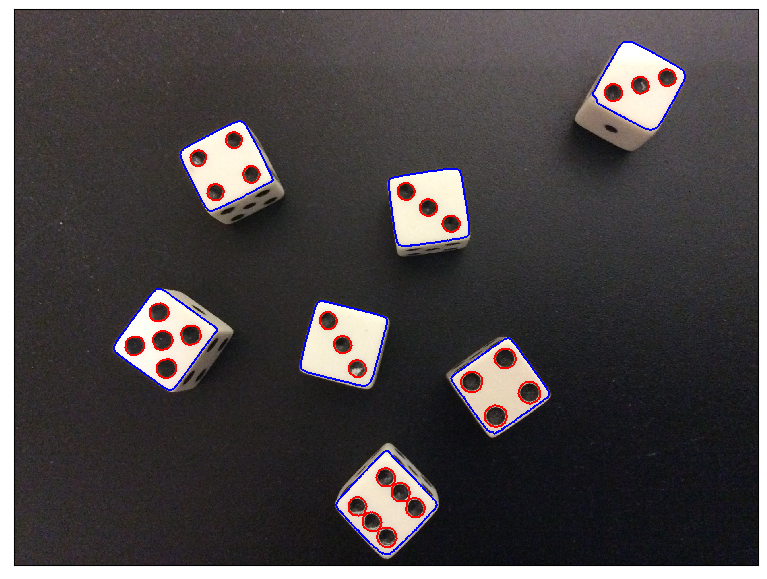

In [8]:
# Draw all contours

dice_contours = list(map(contours.__getitem__, dice))
pips_contours = list(map(contours.__getitem__, pips))

image = get_image(img2)
cv2.drawContours(
    image=image, contours=dice_contours,
    contourIdx=-1, color=(0, 0, 255), thickness=5)
cv2.drawContours(
    image=image, contours=pips_contours,
    contourIdx=-1, color=(255, 0, 0), thickness=5)
show_image(image)

But wait! The total rolls **should be 28**, not 27, should it not? What went wrong? The answer lies in the pip contours for the die showing 6 rolls. That die happens to be associated with the contour with index zero, which only has five children in the hierarchy tree diagram above. If we draw only the first contour in the first die, we see this: **there are 2 merged pips**.

We might have been able to prevent that problem when taking the image, when blurring the image, or when making the binary image with thresholding. Care must be taken when working with image processing, especially in scientific applications, to make sure that the results reported by the program are reliable.

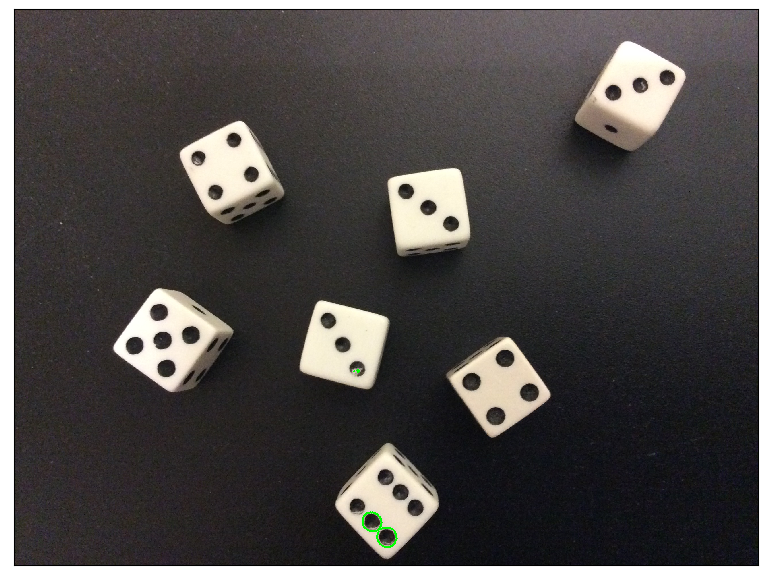

In [9]:
# Draw "wrong" contours
l = []  # list of "wrong" contours

for i, c in enumerate(hierarchy[0]):
    if c[3] == 12:  # 2 contours inside a pip
        l.append(contours[i])

for i, c in enumerate(hierarchy[0]):
    if c[0] == 2:  # 2 pips are merged
        l.append(contours[i])

image = get_image(img2)
cv2.drawContours(
    image=image, contours=l, contourIdx=-1,
    color=(0, 255, 0), thickness=5)
show_image(image)

### Bounding boxes and cropping
Find **bounding boxes**. A bounding box is the smallest rectangle that completely contains a given contour.

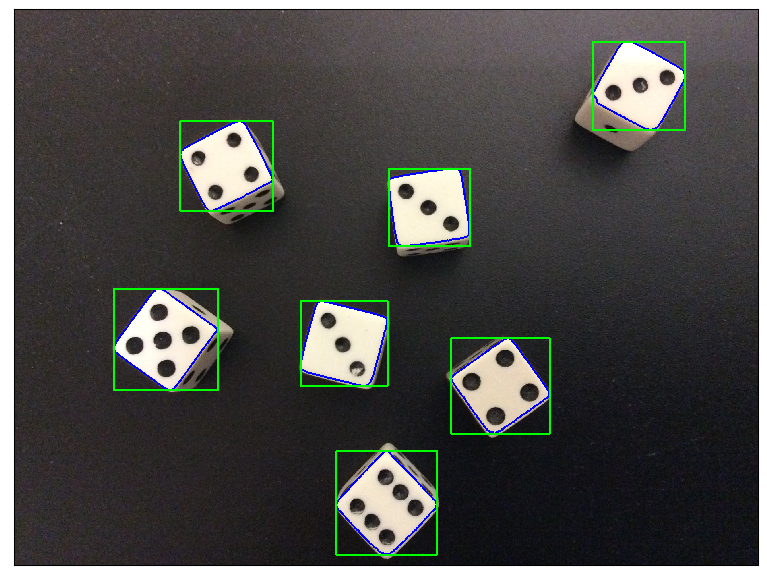

In [10]:
# Draw bounding boxes around dice contours
image = get_image(img2)

cv2.drawContours(
    image=image, contours=dice_contours,
    contourIdx=-1, color=(0, 0, 255), thickness=5)

for i in dice_contours:
    x, y, w, h = cv2.boundingRect(i)
    cv2.rectangle(img=image, pt1=(x, y), pt2=(x+w, y+h),
                  color=(0, 255, 0), thickness=5)
show_image(image)

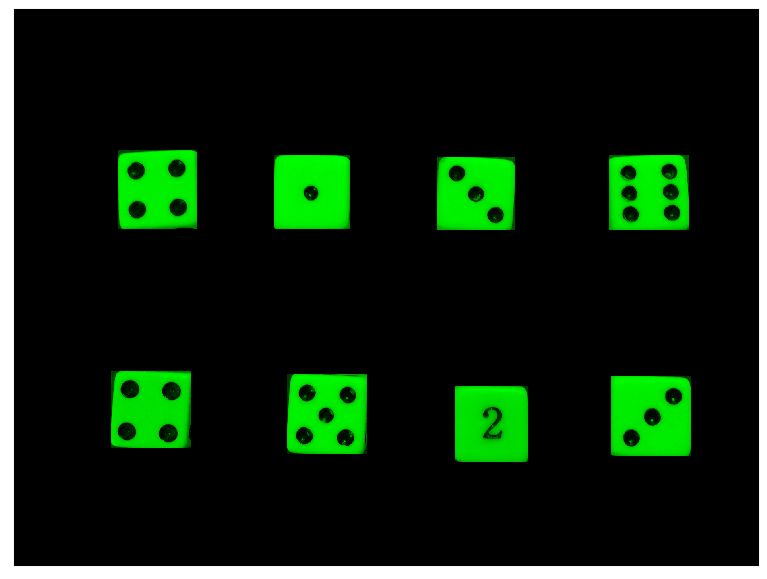

In [11]:
# Crop the image using bounding boxes
image = get_image(img3)

# Create binary image
threshold = 200
gray = get_gray(img3)
blur = cv2.GaussianBlur(src=gray, ksize=(5, 5), sigmaX=0)
t, binary = cv2.threshold(src=blur, thresh=threshold,
                          maxval=255, type=cv2.THRESH_BINARY)
# Find outermost contours
contours, _ = get_contours(
    image=binary, 
    mode=cv2.RETR_EXTERNAL,  # find outermost contours
    method=cv2.CHAIN_APPROX_SIMPLE)

# Create all-black mask image
mask = np.zeros(shape=image.shape, dtype="uint8")
for i in contours:
    x, y, w, h = cv2.boundingRect(i)
    cv2.rectangle(img=mask, pt1=(x, y), pt2=(x+w, y+h),
                  color=(0, 255, 0), thickness=-1)

# Apply mask to the original image
image = cv2.bitwise_and(src1=image, src2=mask)

show_image(image)

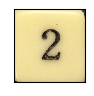

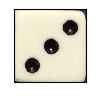

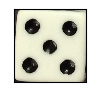

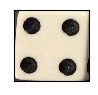

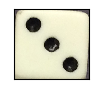

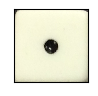

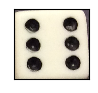

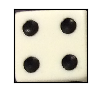

In [12]:
# Extract dice images
image = get_image(img3)
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    sub_img = image[y : y + h, x : x + w, :]
    show_image(sub_img, (1, 1))

### Getting more information from contours: moments
Once we have the contours, we can use them to get the **moments** for the corresponding objects in the image. The moments of an object are weighted averages of pixel intensities, or functions upon those averages, and the precise details of the mathematics involved is fairly complicated. Luckily, we can easily use moments to determine things like the center of an object, the area inside a contour, and more, without worrying about the mathematics behind the scenes.

The grayscale histogram for `dots` image shows that there is a large spike, representing the white background, just above 200.

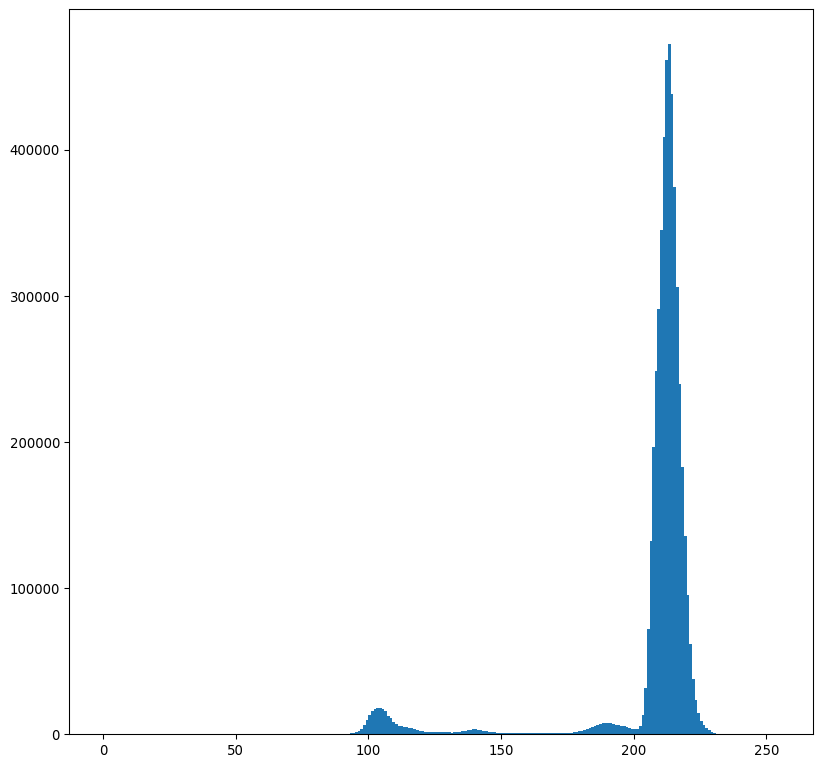

In [13]:
show_hist(img4)

Our strategy for counting the number of **yellow** dots is as follows:
  01. Read the image, make a grayscale version, blur it, and apply thresholding to create a binary image.
  02. Use the binary image to find the contours in the image.
  03. Determine the average size of the contours. This will be used to ignore small contours that represent noise rather than dots.
  04. Iterate through the contours, and for all contours that are big enough:
      * Using the moments of the contour, find the contour centroid.
      * Determine the average color around the contour centroid.
      * Find the Euclidean distance between the average color and three reference colors: yellow, blue, and green.
      * If the average color is closest the the yellow reference color, add one to the count of yellow dots
  05. Output the number of yellow dots.

Dots total: 80
Yellow dots: 24


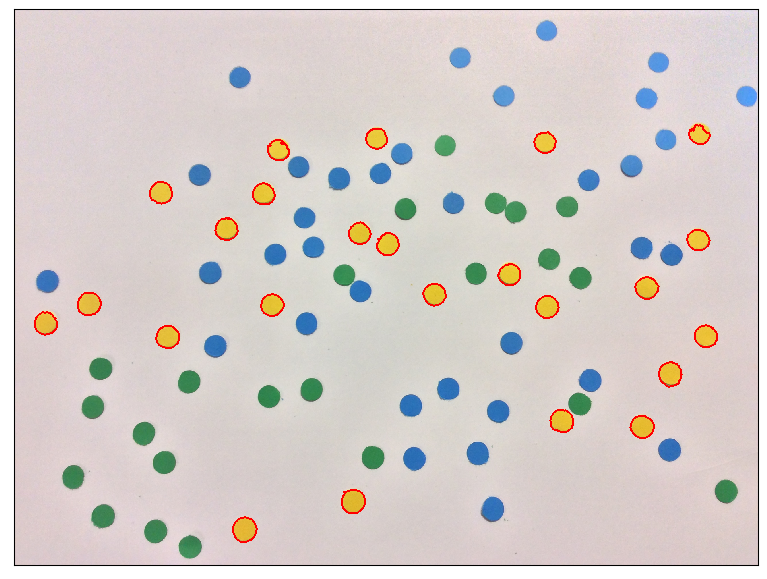

In [14]:
# Count yellow dots on the image
image = get_image(img4)
cv2_img = cv2.imread(img4)  # read image


def color_distance(color1, color2):
    """ Compute distance between two colors,
        as a 3D Euclidean distance. """
    # Compute sum of square of differences between each channel
    d = (color1[0] - color2[0])**2 + \
        (color1[1] - color2[1])**2 + \
        (color1[2] - color2[2])**2

    # Square root of sum is the Euclidean distance
    # between the two colors
    return math.sqrt(d)


def get_contours_2(name, thresh=200):
    """ Draw contours on the image and show it """
    # Create binary image
    threshold = thresh
    gray = get_gray(name)
    blur = cv2.GaussianBlur(src=gray, ksize=(5, 5), sigmaX=0)
    # Get INVERTED binary image
    t, binary = cv2.threshold(src=blur, thresh=threshold,
                              maxval=255, type=cv2.THRESH_BINARY_INV)

    # Find outermost contours
    contours, _ = get_contours(
        image=binary, 
        mode=cv2.RETR_EXTERNAL,  # find outermost contours
        method=cv2.CHAIN_APPROX_SIMPLE)

    return contours


# Determine average contours length
contours = get_contours_2(img4, 200)
avg = 0
for c in contours:
    avg += len(c)
avg /= len(contours)
avg /= 2  # avg = avg / 2

# create reference colors
YELLOW = (0, 255, 255)
GREEN = (0, 255, 0)
BLUE = (255, 0, 0)

yellow_count = 0  # number of yellow dots
yellow_contours = []  # list of yellow contours
i = 0
for c in contours:  # for each contour...
    if len(c) > avg:
        i += 1
        # Find centroid of shape
        M = cv2.moments(array=c)
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        # Find average color for 9 pixel kernel around centroid
        b = cv2_img[cy - 4 : cy + 5, cx - 4 : cx + 5, 0]
        g = cv2_img[cy - 4 : cy + 5, cx - 4 : cx + 5, 1]
        r = cv2_img[cy - 4 : cy + 5, cx - 4 : cx + 5, 2]
        b_average = np.mean(b)
        g_average = np.mean(g)
        r_average = np.mean(r)
        color = (b_average, g_average, r_average)

        # Find distances to known reference colors
        dist = []
        dist.append(color_distance(YELLOW, color))
        dist.append(color_distance(GREEN, color))
        dist.append(color_distance(BLUE, color))

        # Which one is closest?
        min_dist = min(dist)
        # If it was yellow, count the shape
        if dist.index(min_dist) == 0:
            yellow_count += 1
            yellow_contours.append(c)

print("Dots total:", i)
print("Yellow dots:", yellow_count)

image = get_image(img4)
cv2.drawContours(
    image=image, contours=yellow_contours,
    contourIdx=-1, color=(255, 0, 0), thickness=5)
show_image(image)

There is an obstacle: *green and blue dots at the center of the image have one contour*.

Check it by changing `if dist.index(min_dist) == 0:` string to `if dist.index(min_dist) == 1:` and `if dist.index(min_dist) == 2:`.

### Measuring size based on a reference object
We can also use contours to automatically determine the size of objects in the image, based on a **reference object** we intentionally place into the image.

Test image was created with a flatbed scanner. The background was a plain white sheet of paper with a **one inch black square** placed in the upper left. The leaf was placed in front of the paper, the whole collection was placed on the scanner, and the image was captured. Since we know the size of the reference square, we can write a program to find the leaf and automatically determine its size. Our plan will be:

  01. Load the image as grayscale, blur it, threshold it, and find the contours.
  02. Find the contour corresponding to the reference square, and measure the number of pixels in the width and height of the square’s sides.
  03. Find the largest contour (which should be the leaf), and measure the number of pixels in its bounding rectangle sizes.
  04. Calculate the width and height of the leaf.

Leaf size: 3.62×7.43 cm


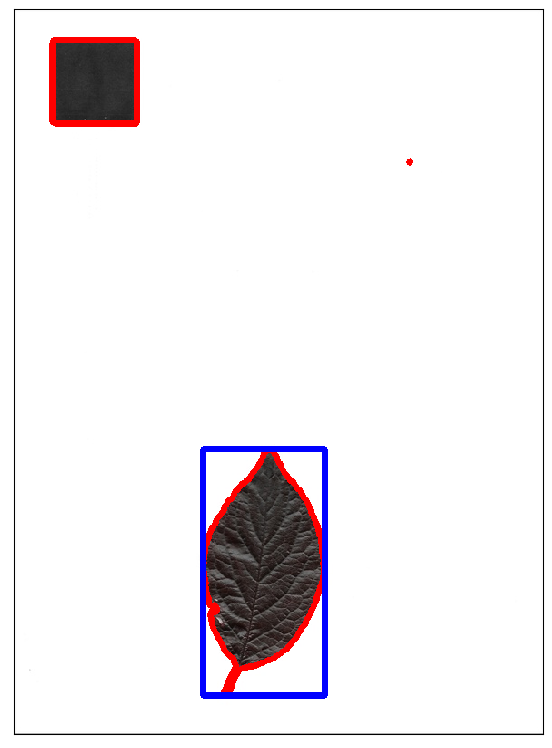

In [15]:
contours = get_contours_2(img5, 200)

# Determine average length of contours
avg = 0
for c in contours:
    avg += len(c)
avg /= len(contours)

# Get the largest contour
largest_id = -1
largest_size = -1
scale_x, scale_y = 0, 0
for i, c in enumerate(contours):
    if len(c) > largest_size:
        largest_size = len(c)
        largest_id = i

    # Now only look at the larger contours
    if len(c) > avg / 11:
        # Get approximating polygon
        epsilon = 0.1 * cv2.arcLength(curve=c, closed=True)
        approx = cv2.approxPolyDP(curve=c, epsilon=epsilon, closed=True)

        # The one with four vertices should be the reference
        if len(approx) == 4:
            # Save bounding rectangle info
            x, y, w, h = cv2.boundingRect(c)

            # Calculate cm per pixels scale
            scale_x = 2.54 / w
            scale_y = 2.54 / h

# Get bounding box for the largest contour
x, y, w, h = cv2.boundingRect(contours[largest_id])
# Calculate height and width of the leaf
width = w * scale_x
height = h * scale_y

# Print results
print(f"Leaf size: {width:0.2f}×{height:0.2f} cm")

image = get_image(img5)
cv2.drawContours(
    image=image, contours=contours,
    contourIdx=-1, color=(255, 0, 0), thickness=5)
cv2.rectangle(img=image, pt1=(x, y), pt2=(x+w, y+h),
              color=(0, 0, 255), thickness=5)
show_image(image)